# Tree-based Models Comparison - Classification

# [x] Preparation

## [x.1] Libraries and Paths

In [1]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

from hyperparameter_optimizer import HyperparameterOptimizer

In [2]:
# Raw Data Path
RAW_DATA_PATH = '/data/raw/telco_customer_churn.csv'

# Initially Processed Data Paths
PROCESSED_TRAIN_PATH = '/data/processed/train.csv'
PROCESSED_TEST_PATH = '/data/processed/test.csv'

# Training-Ready Processed Data Paths
TRAIN_FEATURES_PATH = '/data/processed/train_transformed.csv'
TEST_FEATURES_PATH = '/data/processed/test_transformed.csv'

## [x.2] Data Ingestion

In [ ]:
# [1] Load Raw Data
def load_data(file_path: str) -> pd.DataFrame:
    """Load the raw dataset from a CSV file."""

    df = pd.read_csv(file_path)
    return df


# [2] Preprocess Data
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """Preprocess the raw dataset - handle missing values and encode categorical variables."""
    
    # Drop customerID column
    df = df.drop(columns=['customerID'])
    
    # Convert TotalCharges to numeric
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    
    # Fill missing values
    df = df.fillna(df.median(numeric_only=True))
    
    # Encode categorical variables
    cat_cols = df.select_dtypes(include='object').columns
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        
    return df


# [3] Split and Save Data
def split_and_save(df):
    """Split into training and testing datasets and save them."""
    # Split the Data
    train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
    
    # Save the Data
    train_df.to_csv(PROCESSED_TRAIN_PATH, index=False)
    test_df.to_csv(PROCESSED_TEST_PATH, index=False)
    
    print("Data Saved Successfully!")

In [ ]:
# Load Raw Data
raw_df = load_data(RAW_DATA_PATH)

# Preprocess Data
processed_df = preprocess_data(raw_df)

# Split and Save Data
split_and_save(processed_df)

## [x.3] Feature Engineering

In [ ]:
# [1] Load the Data
def load_processed_data():
    """Load preprocessed data."""
    
    train_df = pd.read_csv(PROCESSED_TRAIN_PATH)
    test_df = pd.read_csv(PROCESSED_TEST_PATH)

    return train_df, test_df


# [2] Create Feature Pipeline
def create_feature_pipeline():
    """Create pipeline for feature engineering."""
    
    numeric_features = [
        "tenure", "MonthlyCharges", "TotalCharges"
    ]
    categorical_features = [
        "gender", "Partner", "Dependents", "PhoneService", 
        "MultipleLines", "InternetService", "OnlineSecurity", 
        "OnlineBackup", "DeviceProtection", "TechSupport", 
        "StreamingTV", "StreamingMovies", "Contract", 
        "PaperlessBilling", "PaymentMethod"
    ]
    
    # Numeric Features Pipeline (impute missing values and perform scaling)
    numeric_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Categorical Features Pipeline - (impute missing values and perform one-hot-encoding)
    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combine Both Pipelines
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_pipeline, numeric_features),
            ('cat', categorical_pipeline, categorical_features)
        ])
    
    return preprocessor


# [4] Function to Transform the Features
def transform_features(preprocessor, train_df, test_df):
    """Apply feature engineering transformations to train and test data."""
    
    x_train = train_df.drop(columns=["Churn"])
    y_train = train_df["Churn"]
    
    x_test = test_df.drop(columns=["Churn"])
    y_test = test_df["Churn"]
    
    # Perform Transformations
    x_train_transformed = preprocessor.fit_transform(x_train)
    x_test_transformed = preprocessor.transform(x_test)
    
    return x_train_transformed, x_test_transformed, y_train, y_test


# [5] Save Transformed Data
def save_transformed_data(x_train, x_test, y_train, y_test):
    """Function to save transformed data to CSV files."""
    
    # Combine Training Data
    train_data = pd.DataFrame(x_train)
    train_data["Churn"] = y_train
    
    # Combine Testing Data
    test_data = pd.DataFrame(x_test)
    test_data["Churn"] = y_test
    
    # Export the Data
    train_data.to_csv(TRAIN_FEATURES_PATH, index=False)
    test_data.to_csv(TEST_FEATURES_PATH, index=False)
    print("Data transformed and saved successfully!")

In [ ]:
# Load Training and Testing Data
train_df, test_df = load_processed_data()

# Load Preprocessor
preprocessor = create_feature_pipeline()

# Create Train and Test Inputs and Outputs
x_train, x_test, y_train, y_test = transform_features(preprocessor, train_df, test_df)

# Save Training and Testing Data
save_transformed_data(x_train, x_test, y_train, y_test)

# Save the Preprocessor Pipeline
joblib.dump(preprocessor, "/models/preprocessor.pkl")

## [x.4] Loading the Pre-processed Data

In [3]:
train_df = pd.read_csv(TRAIN_FEATURES_PATH)
test_df = pd.read_csv(TEST_FEATURES_PATH)

x_train = train_df.drop(columns=["Churn"])
y_train = train_df["Churn"]

x_test = test_df.drop(columns=["Churn"])
y_test = test_df["Churn"]

In [4]:
# Check for Class Imbalance
yes_count = sum(y_train>0)
total_count = len(y_train)
print(f"Class Imbalance [Yes Percentage]: % {np.round(yes_count/total_count,2)*100}")

Class Imbalance [Yes Percentage]: % 26.0


In [5]:
# Oversampling
from imblearn.over_sampling import SMOTE
from collections import Counter

# Create SMOTE object
smote = SMOTE(random_state=42)

# Apply only to training data
x_train_over, y_train_over = smote.fit_resample(x_train, y_train)

# Check class distribution
print("Before SMOTE:", Counter(y_train))
print("After SMOTE: ", Counter(y_train_over))

Before SMOTE: Counter({0: 4663, 1: 1675})
After SMOTE:  Counter({0: 4663, 1: 4663})


In [6]:
# Function to Plot Results
def plot_ps_iter_opt_sols(ps_iter_opt_sols):
    iterations_index = ps_iter_opt_sols["Iterations' Index"]
    iterations_optimum_value = ps_iter_opt_sols["Iteration's Optimum Value"]

    plt.figure(figsize=(6, 4))
    plt.plot(iterations_index, iterations_optimum_value, marker='o', linestyle='-', color='b')
    plt.title("PSO Iterations vs. Optimum Value")
    plt.xlabel("Iterations' Index")
    plt.ylabel("Iteration's Optimum Value")
    plt.grid(True)
    plt.show()

# [1] Decision Trees

## [1.1] Initialize the Model

In [7]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Model
dt_model = DecisionTreeClassifier(random_state=42)

## [1.2] Optimize the Model

In [10]:
# Define Parameter Space
dt_param_space = {
                    'max_depth': [],
                    'min_samples_split': [],
                    'min_samples_leaf': [],
                    'criterion': []
                }

# Initialize the optimizer
dt_optimizer = HyperparameterOptimizer(
                                        obj_func=dt_model,
                                        params=dt_param_space,
                                        scoring='accuracy',
                                        opt_type='max',
                                        cv=5,
                                        verbose=1
                                    )
                                    
# Run optimization
res_dt = dt_optimizer.optimizePS(
                                    features=x_train_over,
                                    target=y_train_over,
                                    nParticles=5,
                                    bounds=[(3, 15), (3, 15), (1, 10), ['gini', 'entropy']],
                                    w=0.5,
                                    c1=1.5,
                                    c2=1.5,
                                    maxIter=20,
                                    mutation_prob=0.7
                            )

PS hyperparameter optimization has started . . .
Initializing Global Best Position and Score . . .
Initializing Swarm Particles . . .
Starting Optimization Main Loop . . .
Iteration #1
Corresponding Optimal Solution: [15 3 1 'entropy']
Corresponding Optimum: 0.7960534928694372
------
Iteration #2
Corresponding Optimal Solution: [15 3 1 'entropy']
Corresponding Optimum: 0.7960534928694372
------
Iteration #3
Corresponding Optimal Solution: [15 3 1 'entropy']
Corresponding Optimum: 0.7960534928694372
------
Iteration #4
Corresponding Optimal Solution: [15 3 1 'entropy']
Corresponding Optimum: 0.7960534928694372
------
Iteration #5
Corresponding Optimal Solution: [15 3 10 'gini']
Corresponding Optimum: 0.797231968138755
------
Iteration #6
Corresponding Optimal Solution: [15 15 1 'entropy']
Corresponding Optimum: 0.7983049288955171
------
Iteration #7
Corresponding Optimal Solution: [15 15 1 'entropy']
Corresponding Optimum: 0.7983049288955171
------
Iteration #8
Corresponding Optimal Sol

In [11]:
# Get the Optimal Hyperparameter Values
dt_max_depth_optimal = dt_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][0]
print(f"Optimal max_depth: {dt_max_depth_optimal}")

dt_min_samples_split_optimal = dt_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][1]
print(f"Optimal min_samples_split: {dt_min_samples_split_optimal}")

dt_min_samples_leaf_optimal = dt_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][2]
print(f"Optimal min_samples_leaf: {dt_min_samples_leaf_optimal}")

dt_criterion_optimal = dt_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][3]
print(f"Optimal criterion: {dt_criterion_optimal}")

Optimal max_depth: 15
Optimal min_samples_split: 15
Optimal min_samples_leaf: 1
Optimal criterion: entropy


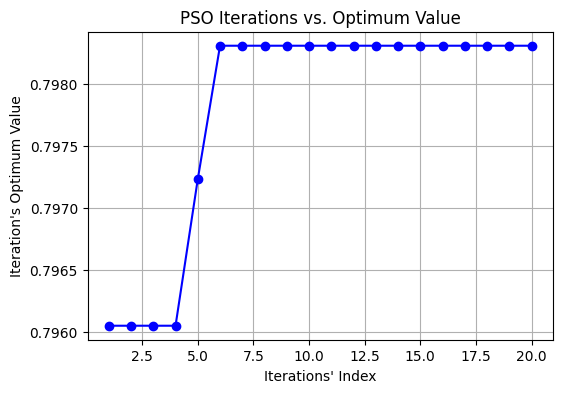

In [14]:
# Plot the Results
plot_ps_iter_opt_sols(dt_optimizer.PS_iterOptSols)

## [1.3] Train the Model

In [15]:
# Build the Final Model
dt_model_final = DecisionTreeClassifier(
                                            random_state=42,
                                            max_depth=dt_max_depth_optimal,
                                            min_samples_split=dt_min_samples_split_optimal,
                                            min_samples_leaf=dt_min_samples_leaf_optimal,
                                            criterion=dt_criterion_optimal
                                        )

# Fit the Final Model
dt_model_final.fit(x_train_over, y_train_over)

DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_split=15,
                       random_state=42)

## [1.4] Test the Results

In [16]:
# Import the required libraries
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predict the target values
dt_y_pred = dt_model_final.predict(x_test)

### [1.4.1] Confusion Matrix

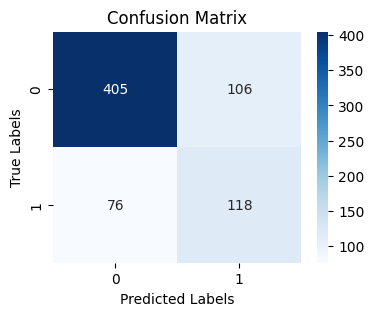

In [20]:
# Calculate the Confusion Matrix
dt_conf_matrix = confusion_matrix(y_test, dt_y_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(4, 3))
sns.heatmap(dt_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### [1.4.2] Classification Report

In [21]:
print(classification_report(y_test, dt_y_pred))

              precision    recall  f1-score   support

           0       0.84      0.79      0.82       511
           1       0.53      0.61      0.56       194

    accuracy                           0.74       705
   macro avg       0.68      0.70      0.69       705
weighted avg       0.76      0.74      0.75       705



### [1.4.3] Metrics

In [22]:
dt_accuracy = accuracy_score(y_test, dt_y_pred)
dt_precision = precision_score(y_test, dt_y_pred)
dt_recall = recall_score(y_test, dt_y_pred)
dt_f1 = f1_score(y_test, dt_y_pred)
dt_roc_auc = roc_auc_score(y_test, dt_y_pred)

print("Accuracy:", dt_accuracy)
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("F1:", dt_f1)
print("ROC-AUC:", dt_roc_auc)

Accuracy: 0.7418439716312056
Precision: 0.5267857142857143
Recall: 0.6082474226804123
F1: 0.5645933014354066
ROC-AUC: 0.7004055117315957


## [1.5] MLFlow

In [23]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# Set Tracking
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Set Experiment Name
mlflow.set_experiment("dt_churn-classification")

# Infer model signature (schema)
dt_signature = infer_signature(x_train_over, dt_y_pred)

# Use a sample of your input as input_example
dt_input_example = x_train_over.sample(5)

# Start MLflow run
with mlflow.start_run():
    # Log parameters
    mlflow.log_param("random_state", 42)
    mlflow.log_param("max_depth", dt_max_depth_optimal)
    mlflow.log_param("min_samples_split", dt_min_samples_split_optimal)
    mlflow.log_param("min_samples_leaf", dt_min_samples_leaf_optimal)
    mlflow.log_param("criterion", dt_criterion_optimal)
    
    # Log metrics
    mlflow.log_metric("accuracy", dt_accuracy)
    mlflow.log_metric("precision", dt_precision)
    mlflow.log_metric("recall", dt_recall)
    mlflow.log_metric("f1", dt_f1)
    mlflow.log_metric("roc_auc", dt_roc_auc)

    # Log model
    mlflow.sklearn.log_model(dt_model_final, "decision_tree_model", signature=dt_signature, input_example=dt_input_example)


🏃 View run clean-grouse-273 at: http://127.0.0.1:5000/#/experiments/806818593882192828/runs/bafe8fce5f0e4c288d54d67cb99137c3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/806818593882192828


# [2] Random Forest

## [2.1] Initialize the Model

In [24]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Model
rf_model = RandomForestClassifier(random_state=42)

## [2.2] Optimize the Model

In [25]:
# Define Parameter Space
rf_param_space = {
                    'n_estimators': [],
                    'max_depth': [],
                    'min_samples_split': [],
                    'min_samples_leaf': [],
                    'max_features': []
                }

# Initialize the optimizer
rf_optimizer = HyperparameterOptimizer(
                                        obj_func=rf_model,
                                        params=rf_param_space,
                                        scoring='accuracy',
                                        opt_type='max',
                                        cv=5,
                                        verbose=1
                                    )
                                    
# Run optimization
res_rf = rf_optimizer.optimizePS(
                                    features=x_train_over,
                                    target=y_train_over,
                                    nParticles=5,
                                    bounds=[(50, 500), (3, 15), (3, 15), (3, 10), ['sqrt', 'log2']],
                                    w=0.5,
                                    c1=1.5,
                                    c2=1.5,
                                    maxIter=20,
                                    mutation_prob=0.7
                                )

PS hyperparameter optimization has started . . .
Initializing Global Best Position and Score . . .
Initializing Swarm Particles . . .
Starting Optimization Main Loop . . .
Iteration #1
Corresponding Optimal Solution: [50 15 3 3 'log2']
Corresponding Optimum: 0.8404453333103454
------
Iteration #2
Corresponding Optimal Solution: [50 15 3 3 'log2']
Corresponding Optimum: 0.8404453333103454
------
Iteration #3
Corresponding Optimal Solution: [50 15 3 3 'sqrt']
Corresponding Optimum: 0.8434481292150491
------
Iteration #4
Corresponding Optimal Solution: [50 15 3 3 'sqrt']
Corresponding Optimum: 0.8434481292150491
------
Iteration #5
Corresponding Optimal Solution: [500 15 3 3 'log2']
Corresponding Optimum: 0.8441984546376675
------
Iteration #6
Corresponding Optimal Solution: [500 15 3 3 'log2']
Corresponding Optimum: 0.8441984546376675
------
Iteration #7
Corresponding Optimal Solution: [500 15 3 3 'sqrt']
Corresponding Optimum: 0.8470936671178044
------
Iteration #8
Corresponding Optimal

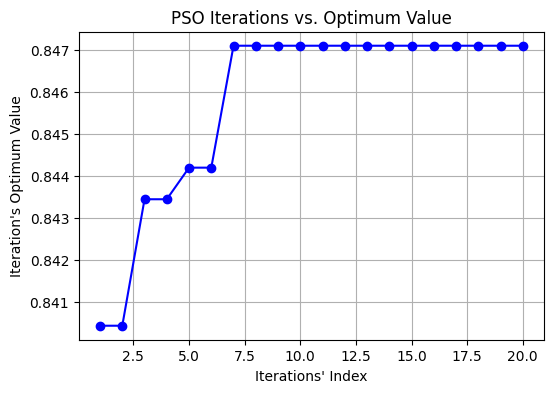

In [26]:
# Plot Results
plot_ps_iter_opt_sols(rf_optimizer.PS_iterOptSols)

In [27]:
# Get the Optimal Hyperparameter Values
rf_n_estimators_optimal = rf_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][0]
print(f"Optimal n_estimators: {rf_n_estimators_optimal}")

rf_max_depth_optimal = rf_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][1]
print(f"Optimal max_depth: {rf_max_depth_optimal}")

rf_min_samples_split_optimal = rf_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][2]
print(f"Optimal min_samples_split: {rf_min_samples_split_optimal}")

rf_min_samples_leaf_optimal = rf_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][3]
print(f"Optimal min_samples_leaf: {rf_min_samples_leaf_optimal}")

rf_max_features_optimal = rf_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][4]
print(f"Optimal max_features: {rf_max_features_optimal}")

Optimal n_estimators: 500
Optimal max_depth: 15
Optimal min_samples_split: 3
Optimal min_samples_leaf: 3
Optimal max_features: sqrt


## [2.3] Train the Model

In [28]:
# Build the Final Model
rf_model_final = RandomForestClassifier(
                                          class_weight='balanced',
                                          random_state=42,
                                          n_estimators=rf_n_estimators_optimal,
                                          max_depth=rf_max_depth_optimal,
                                          min_samples_split=rf_min_samples_split_optimal,
                                          min_samples_leaf=rf_min_samples_leaf_optimal,
                                          max_features=rf_max_features_optimal
                                        )

# Fit the Final Model
rf_model_final.fit(x_train_over, y_train_over)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=3, min_samples_split=3,
                       n_estimators=500, random_state=42)

## [2.4] Test the Results

In [29]:
# Import the required libraries
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predict the target values
rf_y_pred = rf_model_final.predict(x_test)

### [2.4.1] Confusion Matrix

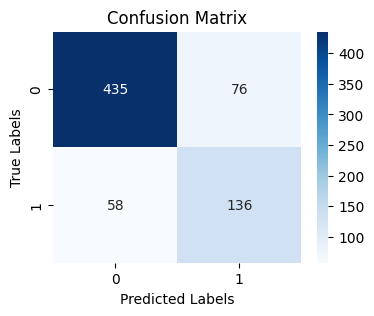

In [30]:
# Calculate the Confusion Matrix
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(4, 3))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### [2.4.2] Classification Report

In [31]:
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87       511
           1       0.64      0.70      0.67       194

    accuracy                           0.81       705
   macro avg       0.76      0.78      0.77       705
weighted avg       0.82      0.81      0.81       705



### [2.4.3] Metrics

In [32]:
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
rf_f1 = f1_score(y_test, rf_y_pred)
rf_roc_auc = roc_auc_score(y_test, rf_y_pred)

print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1:", rf_f1)
print("ROC-AUC:", rf_roc_auc)

Accuracy: 0.8099290780141843
Precision: 0.6415094339622641
Recall: 0.7010309278350515
F1: 0.6699507389162561
ROC-AUC: 0.7761514717453144


## [2.5] MLFlow

In [33]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# Set Tracking
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Set Experiment Name
mlflow.set_experiment("rf_churn-classification")

# Infer model signature (schema)
rf_signature = infer_signature(x_train_over, dt_y_pred)

# Use a sample of your input as input_example
rf_input_example = x_train_over.sample(5)

# Start MLflow run
with mlflow.start_run():
    # Log parameters
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_estimators", rf_n_estimators_optimal)
    mlflow.log_param("max_depth", rf_max_depth_optimal)
    mlflow.log_param("min_samples_split", rf_min_samples_split_optimal)
    mlflow.log_param("min_samples_leaf", rf_min_samples_leaf_optimal)
    mlflow.log_param("max_features", rf_max_features_optimal)
    
    # Log metrics
    mlflow.log_metric("accuracy", rf_accuracy)
    mlflow.log_metric("precision", rf_precision)
    mlflow.log_metric("recall", rf_recall)
    mlflow.log_metric("f1", rf_f1)
    mlflow.log_metric("roc_auc", rf_roc_auc)

    # Log model
    mlflow.sklearn.log_model(rf_model_final, "random_forest_model", signature=rf_signature, input_example=rf_input_example)


🏃 View run trusting-bass-608 at: http://127.0.0.1:5000/#/experiments/571980083914650300/runs/71da3798ed35494684d40451689b73fc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/571980083914650300


# [3] AdaBoost

## [3.1] Initialize the Model

In [34]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Initialize Base Tree
base_tree = DecisionTreeClassifier(random_state=42)

# Initialize the Model
ada_model = AdaBoostClassifier(estimator=base_tree, random_state=42)

## [3.2] Optimize the Model

In [44]:
# Define Parameter Space
ada_param_space = {
                    'n_estimators': [],
                    'learning_rate': [],
                    'estimator__max_depth': [],
                    'estimator__min_samples_split': [],
                    'estimator__min_samples_leaf': []
                }

# Initialize the optimizer
ada_optimizer = HyperparameterOptimizer(
                                        obj_func=ada_model,
                                        params=ada_param_space,
                                        scoring='accuracy',
                                        opt_type='max',
                                        cv=5,
                                        verbose=1
                                    )
                                    
# Run optimization
res_ada = ada_optimizer.optimizePS(
                                        features=x_train_over,
                                        target=y_train_over,
                                        nParticles=5,
                                        bounds=[(50, 500), (0.01, 1.00), (1, 3), (2, 10), (1, 5)],
                                        w=0.5,
                                        c1=1.5,
                                        c2=1.5,
                                        maxIter=20,
                                        mutation_prob=0.7
                                    )

PS hyperparameter optimization has started . . .
Initializing Global Best Position and Score . . .
Initializing Swarm Particles . . .
Starting Optimization Main Loop . . .
Iteration #1
Corresponding Optimal Solution: [500 1.0 3 10 1]
Corresponding Optimum: 0.8491308558112003
------
Iteration #2
Corresponding Optimal Solution: [500 1.0 3 2 1]
Corresponding Optimum: 0.8503106528854139
------
Iteration #3
Corresponding Optimal Solution: [500 1.0 3 2 1]
Corresponding Optimum: 0.8503106528854139
------
Iteration #4
Corresponding Optimal Solution: [500 1.0 3 2 1]
Corresponding Optimum: 0.8503106528854139
------
Iteration #5
Corresponding Optimal Solution: [500 1.0 3 2 1]
Corresponding Optimum: 0.8503106528854139
------
Iteration #6
Corresponding Optimal Solution: [500 1.0 3 2 1]
Corresponding Optimum: 0.8503106528854139
------
Iteration #7
Corresponding Optimal Solution: [500 1.0 3 2 1]
Corresponding Optimum: 0.8503106528854139
------
Iteration #8
Corresponding Optimal Solution: [500 1.0 3 2

In [45]:
# Get the Optimal Hyperparameter Values
ada_n_estimators_optimal = ada_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][0]
print(f"Optimal n_estimators: {ada_n_estimators_optimal}")

ada_learning_rate_optimal = ada_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][1]
print(f"Optimal learning_rate: {ada_learning_rate_optimal}")

ada_base_estimator__max_depth_optimal = ada_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][2]
print(f"Optimal base_estimator__max_depth: {ada_base_estimator__max_depth_optimal}")

ada_base_estimator__min_samples_split_optimal = ada_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][3]
print(f"Optimal base_estimator__min_samples_split: {ada_base_estimator__min_samples_split_optimal}")

ada_base_estimator__min_samples_leaf_optimal = ada_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][4]
print(f"Optimal base_estimator__min_samples_leaf: {ada_base_estimator__min_samples_leaf_optimal}")

Optimal n_estimators: 500
Optimal learning_rate: 1.0
Optimal base_estimator__max_depth: 3
Optimal base_estimator__min_samples_split: 2
Optimal base_estimator__min_samples_leaf: 1


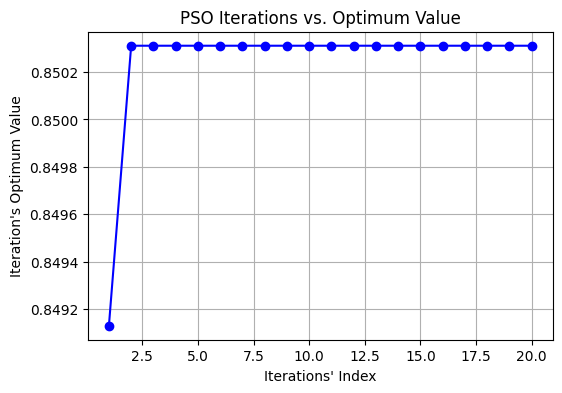

In [46]:
# Plot the Results
plot_ps_iter_opt_sols(ada_optimizer.PS_iterOptSols)

## [3.3] Train the Model

In [47]:
# Build the Final Model
ada_model_final = AdaBoostClassifier(
                                      random_state=42,
                                      estimator = DecisionTreeClassifier(
                                                                          random_state=42,
                                                                          max_depth=ada_base_estimator__max_depth_optimal,
                                                                          min_samples_split=ada_base_estimator__min_samples_split_optimal,
                                                                          min_samples_leaf=ada_base_estimator__min_samples_leaf_optimal
                                                                        ),
                                                                        
                                      n_estimators=ada_n_estimators_optimal,
                                      learning_rate=ada_learning_rate_optimal
                                      )

# Fit the Final Model
ada_model_final.fit(x_train_over, y_train_over)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    random_state=42),
                   n_estimators=500, random_state=42)

## [3.4] Test the Results

In [49]:
# Import the required libraries
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predict the target values
ada_y_pred = ada_model_final.predict(x_test)

### [3.4.1] Confusion Matrix

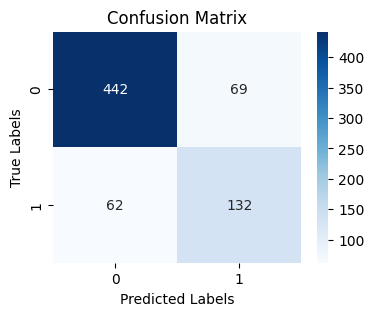

In [50]:
# Calculate the Confusion Matrix
ada_conf_matrix = confusion_matrix(y_test, ada_y_pred)


# Plot the Confusion Matrix
plt.figure(figsize=(4, 3))
sns.heatmap(ada_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### [3.4.2] Classification Report

In [51]:
print(classification_report(y_test, ada_y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       511
           1       0.66      0.68      0.67       194

    accuracy                           0.81       705
   macro avg       0.77      0.77      0.77       705
weighted avg       0.82      0.81      0.82       705



### [3.4.3] Metrics

In [52]:
ada_accuracy = accuracy_score(y_test, ada_y_pred)
ada_precision = precision_score(y_test, ada_y_pred)
ada_recall = recall_score(y_test, ada_y_pred)
ada_f1 = f1_score(y_test, ada_y_pred)
ada_roc_auc = roc_auc_score(y_test,ada_y_pred)

print("Accuracy:", ada_accuracy)
print("Precision:", ada_precision)
print("Recall:", ada_recall)
print("F1:", ada_f1)
print("ROC-AUC:", ada_roc_auc)

Accuracy: 0.8141843971631205
Precision: 0.6567164179104478
Recall: 0.6804123711340206
F1: 0.6683544303797468
ROC-AUC: 0.7726915084632922


## [3.5] MLFlow

In [53]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# Set Tracking
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Set Experiment Name
mlflow.set_experiment("ada_churn-classification")

# Infer model signature (schema)
ada_signature = infer_signature(x_train_over, ada_y_pred)

# Use a sample of your input as input_example
ada_input_example = x_train_over.sample(5)

# Start MLflow run
with mlflow.start_run():
    # Log parameters
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_estimators", ada_n_estimators_optimal)
    mlflow.log_param("learning_rate", ada_learning_rate_optimal)

    mlflow.log_param("max_depth", ada_base_estimator__max_depth_optimal)
    mlflow.log_param("min_samples_split", ada_base_estimator__min_samples_split_optimal)
    mlflow.log_param("min_samples_leaf", ada_base_estimator__min_samples_leaf_optimal)
    
    
    # Log metrics
    mlflow.log_metric("accuracy", ada_accuracy)
    mlflow.log_metric("precision", ada_precision)
    mlflow.log_metric("recall", ada_recall)
    mlflow.log_metric("f1", ada_f1)
    mlflow.log_metric("roc_auc", ada_roc_auc)

    # Log model
    mlflow.sklearn.log_model(ada_model_final, "ada_boost_model", signature=ada_signature, input_example=ada_input_example)


🏃 View run welcoming-toad-52 at: http://127.0.0.1:5000/#/experiments/464069361959716105/runs/d519e46cdd2b405dab48b046f10a4504
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/464069361959716105


# [4] Gradient Boosting

## [4.1] Initialize the Model

In [68]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Model
gb_model = GradientBoostingClassifier(random_state=42)

## [4.2] Optimize the Model

In [56]:
# Define Parameter Space
gb_param_space = {
                    'n_estimators': [],
                    'learning_rate': [],
                    'max_depth': [],
                    'min_samples_split': [],
                    'min_samples_leaf': [],
                    'subsample': [],
                    'max_features': []
                }

# Initialize the optimizer
gb_optimizer = HyperparameterOptimizer(
                                        obj_func=gb_model,
                                        params=gb_param_space,
                                        scoring='accuracy',
                                        opt_type='max',
                                        cv=5,
                                        verbose=1
                                    )
                                    
# Run optimization
res_gb = gb_optimizer.optimizePS(
                                    features=x_train_over,
                                    target=y_train_over,
                                    nParticles=5,
                                    bounds=[(100, 1000), (0.01, 0.20), (3, 10), (2, 10), (1, 10), (0.5, 1.0), ['sqrt', 'log2']],
                                    w=0.5,
                                    c1=1.5,
                                    c2=1.5,
                                    maxIter=20,
                                    mutation_prob=0.7
                            )

PS hyperparameter optimization has started . . .
Initializing Global Best Position and Score . . .
Initializing Swarm Particles . . .
Starting Optimization Main Loop . . .
Iteration #1
Corresponding Optimal Solution: [1000 0.01 10 2 10 0.5 'sqrt']
Corresponding Optimum: 0.8559934369513433
------
Iteration #2
Corresponding Optimal Solution: [1000 0.01 10 2 10 0.5 'sqrt']
Corresponding Optimum: 0.8559934369513433
------
Iteration #3
Corresponding Optimal Solution: [1000 0.01 10 2 1 0.5 'sqrt']
Corresponding Optimum: 0.8585673359022324
------
Iteration #4
Corresponding Optimal Solution: [1000 0.01 10 2 1 0.5 'sqrt']
Corresponding Optimum: 0.8585673359022324
------
Iteration #5
Corresponding Optimal Solution: [1000 0.01 10 2 1 0.5 'sqrt']
Corresponding Optimum: 0.8585673359022324
------
Iteration #6
Corresponding Optimal Solution: [1000 0.01 10 2 1 0.5 'sqrt']
Corresponding Optimum: 0.8585673359022324
------
Iteration #7
Corresponding Optimal Solution: [1000 0.01 10 2 1 0.5 'sqrt']
Corresp

In [57]:
# Get the Optimal Hyperparameter Values
gb_n_estimators_optimal = gb_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][0]
print(f"Optimal n_estimators: {gb_n_estimators_optimal}")

gb_learning_rate_optimal = gb_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][1]
print(f"Optimal learning_rate: {gb_learning_rate_optimal}")

gb_max_depth_optimal = gb_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][2]
print(f"Optimal max_depth: {gb_max_depth_optimal}")

gb_min_samples_split_optimal = gb_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][3]
print(f"Optimal min_samples_split: {gb_min_samples_split_optimal}")

gb_min_samples_leaf_optimal = gb_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][4]
print(f"Optimal min_samples_leaf: {gb_min_samples_leaf_optimal}")

gb_subsample_optimal = gb_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][5]
print(f"Optimal subsample: {gb_subsample_optimal}")

gb_max_features_optimal = gb_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][6]
print(f"Optimal max_features: {gb_max_features_optimal}")

Optimal n_estimators: 1000
Optimal learning_rate: 0.01
Optimal max_depth: 10
Optimal min_samples_split: 2
Optimal min_samples_leaf: 1
Optimal subsample: 1.0
Optimal max_features: sqrt


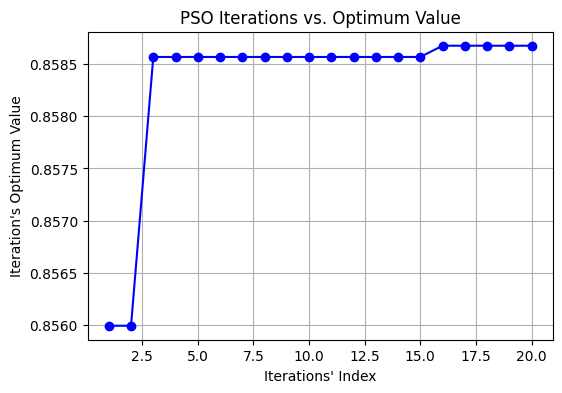

In [58]:
# Plot the Results
plot_ps_iter_opt_sols(gb_optimizer.PS_iterOptSols)

## [4.3] Train the Model

In [59]:
# Build the Final Model
gb_model_final = GradientBoostingClassifier(
                                            n_estimators=gb_n_estimators_optimal,
                                            learning_rate=gb_learning_rate_optimal,
                                            max_depth=gb_max_depth_optimal,
                                            min_samples_split=gb_min_samples_split_optimal,
                                            min_samples_leaf=gb_min_samples_leaf_optimal,
                                            subsample=gb_subsample_optimal,
                                            max_features=gb_max_features_optimal,
                                            random_state=42
                                        )

# Fit the Final Model
gb_model_final.fit(x_train_over, y_train_over)

GradientBoostingClassifier(learning_rate=0.01, max_depth=10,
                           max_features='sqrt', n_estimators=1000,
                           random_state=42)

## [4.4] Test the Results

In [62]:
# Import the required libraries
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predict the target values
gb_y_pred = gb_model_final.predict(x_test)

### [4.4.1] Confusion Matrix

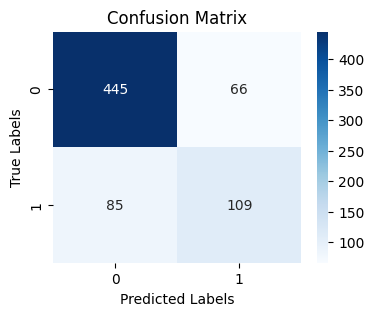

In [63]:
# Calculate the Confusion Matrix
gb_conf_matrix = confusion_matrix(y_test, gb_y_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(4, 3))
sns.heatmap(gb_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### [4.4.2] Classification Report

In [64]:
print(classification_report(y_test, gb_y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       511
           1       0.62      0.56      0.59       194

    accuracy                           0.79       705
   macro avg       0.73      0.72      0.72       705
weighted avg       0.78      0.79      0.78       705



### [4.4.3] Metrics

In [65]:
gb_accuracy = accuracy_score(y_test, gb_y_pred)
gb_precision = precision_score(y_test, gb_y_pred)
gb_recall = recall_score(y_test, gb_y_pred)
gb_f1 = f1_score(y_test, gb_y_pred)
gb_roc_auc = roc_auc_score(y_test, gb_y_pred)

print("Accuracy:", gb_accuracy)
print("Precision:", gb_precision)
print("Recall:", gb_recall)
print("F1:", gb_f1)
print("ROC-AUC:", gb_roc_auc)

Accuracy: 0.7858156028368795
Precision: 0.6228571428571429
Recall: 0.5618556701030928
F1: 0.5907859078590786
ROC-AUC: 0.7163485786914682


## [4.5] MLFlow

In [66]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# Set Tracking
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Set Experiment Name
mlflow.set_experiment("gb_churn-classification")

# Infer model signature (schema)
gb_signature = infer_signature(x_train_over, gb_y_pred)

# Use a sample of your input as input_example
gb_input_example = x_train_over.sample(5)

# Start MLflow run
with mlflow.start_run():
    # Log parameters
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_estimators", gb_n_estimators_optimal)
    mlflow.log_param("learning_rate", gb_learning_rate_optimal)
    mlflow.log_param("max_depth", gb_max_depth_optimal)
    mlflow.log_param("min_samples_split", gb_min_samples_split_optimal)
    mlflow.log_param("min_samples_leaf", gb_min_samples_leaf_optimal)
    mlflow.log_param("subsample", gb_subsample_optimal)
    mlflow.log_param("max_features", gb_max_features_optimal)
    
    # Log metrics
    mlflow.log_metric("accuracy", gb_accuracy)
    mlflow.log_metric("precision", gb_precision)
    mlflow.log_metric("recall", gb_recall)
    mlflow.log_metric("f1", gb_f1)
    mlflow.log_metric("roc_auc", gb_roc_auc)

    # Log model
    mlflow.sklearn.log_model(gb_model_final, "gradient_boost_model", signature=gb_signature, input_example=gb_input_example)


🏃 View run sneaky-crane-266 at: http://127.0.0.1:5000/#/experiments/306606675816563962/runs/92d536b20a12474a9d54d0d4770bfc95
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/306606675816563962


# [5] LightGBM

## [5.1] Initialize the Model

In [96]:
import warnings
warnings.filterwarnings("ignore")

from lightgbm import LGBMClassifier

# Initialize the Model
lgbm_model = LGBMClassifier(verbosity=-1, random_state=42)


## [5.2] Optimize the Model

In [97]:
# Define Parameter Space
lgbm_param_space = {
                    'n_estimators': [],
                    'learning_rate': [],

                    'max_depth': [],
                    'num_leaves': [],

                    'min_child_samples': [],
                    'colsample_bytree': [],

                    'reg_alpha': [],
                    'reg_lambda': [],
                }

# Initialize the optimizer
lgbm_optimizer = HyperparameterOptimizer(
                                            obj_func=lgbm_model,
                                            params=lgbm_param_space,
                                            scoring='accuracy',
                                            opt_type='max',
                                            cv=5,
                                            verbose=1
                                    )
                                    
# Run optimization
res_lgbm = lgbm_optimizer.optimizePS(
                                        features=x_train_over,
                                        target=y_train_over,
                                        nParticles=5,
                                        bounds=[
                                                    (100, 1000), (0.01, 0.20),
                                                    (3, 10), (15, 64),
                                                    (10, 100), (0.5, 1.0),
                                                    (0.0, 1.0), (0.0, 1.0)
                                                ],
                                        w=0.5,
                                        c1=1.5,
                                        c2=1.5,
                                        maxIter=20,
                                        mutation_prob=0.7
                            )

PS hyperparameter optimization has started . . .
Initializing Global Best Position and Score . . .
Initializing Swarm Particles . . .
Starting Optimization Main Loop . . .
Iteration #1
Corresponding Optimal Solution: [100 0.2 10 15 10 1.0 0.0 0.0]
Corresponding Optimum: 0.8510612081871447
------
Iteration #2
Corresponding Optimal Solution: [100 0.2 10 15 10 1.0 0.0 0.0]
Corresponding Optimum: 0.8510612081871447
------
Iteration #3
Corresponding Optimal Solution: [100 0.2 10 15 10 1.0 0.0 0.0]
Corresponding Optimum: 0.8510612081871447
------
Iteration #4
Corresponding Optimal Solution: [100 0.2 10 64 10 0.5 0.0 1.0]
Corresponding Optimum: 0.8514897603222906
------
Iteration #5
Corresponding Optimal Solution: [100 0.2 10 64 10 0.5 0.0 1.0]
Corresponding Optimum: 0.8514897603222906
------
Iteration #6
Corresponding Optimal Solution: [100 0.2 10 64 10 0.5 0.0 1.0]
Corresponding Optimum: 0.8514897603222906
------
Iteration #7
Corresponding Optimal Solution: [1000 0.01 10 64 100 0.5 0.0 1.0]

In [98]:
# Get the Optimal Hyperparameter Values
lgbm_n_estimators_optimal = lgbm_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][0]
print(f"Optimal n_estimators: {lgbm_n_estimators_optimal}")

lgbm_learning_rate_optimal = lgbm_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][1]
print(f"Optimal learning_rate: {lgbm_learning_rate_optimal}")

lgbm_max_depth_optimal = lgbm_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][2]
print(f"Optimal max_depth: {lgbm_max_depth_optimal}")

lgbm_num_leaves_optimal = lgbm_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][3]
print(f"Optimal min_samples_split: {lgbm_num_leaves_optimal}")

lgbm_min_child_samples_optimal = lgbm_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][4]
print(f"Optimal min_child_samples: {lgbm_min_child_samples_optimal}")

lgbm_colsample_bytree_optimal = lgbm_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][5]
print(f"Optimal colsample_bytree: {lgbm_colsample_bytree_optimal}")

lgbm_reg_alpha_optimal = lgbm_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][6]
print(f"Optimal reg_alpha: {lgbm_reg_alpha_optimal}")

lgbm_reg_lambda_optimal = lgbm_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][7]
print(f"Optimal reg_lambda: {lgbm_reg_lambda_optimal}")

Optimal n_estimators: 1000
Optimal learning_rate: 0.01
Optimal max_depth: 10
Optimal min_samples_split: 64
Optimal min_child_samples: 10
Optimal colsample_bytree: 0.5
Optimal reg_alpha: 0.0
Optimal reg_lambda: 0.0


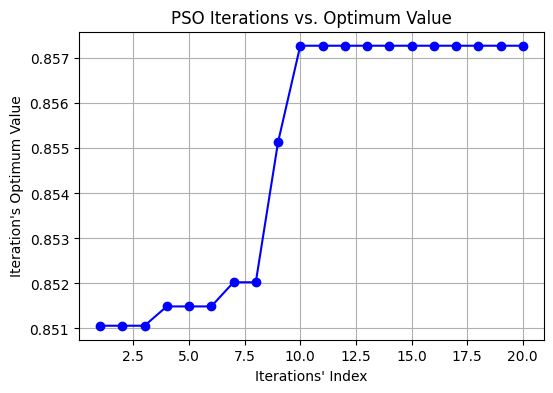

In [99]:
# Plot the Results
plot_ps_iter_opt_sols(lgbm_optimizer.PS_iterOptSols)

## [5.3] Train the Model

In [106]:
# Build the Final Model
lgbm_model_final = LGBMClassifier(
                                        n_estimators=lgbm_n_estimators_optimal,
                                        learning_rate=lgbm_learning_rate_optimal,
                                        max_depth=lgbm_max_depth_optimal,
                                        num_leaves=lgbm_num_leaves_optimal,
                                        min_child_samples=lgbm_min_child_samples_optimal,
                                        colsample_bytree=lgbm_colsample_bytree_optimal,
                                        reg_alpha=lgbm_reg_alpha_optimal,
                                        reg_lambda=lgbm_reg_lambda_optimal,
                                        random_state=42,
                                        verbosity=-1
                                )

# Fit the Final Model
lgbm_model_final.fit(x_train_over, y_train_over)

LGBMClassifier(colsample_bytree=0.5, learning_rate=0.01, max_depth=10,
               min_child_samples=10, n_estimators=1000, num_leaves=64,
               random_state=42, verbosity=-1)

## [5.4] Test the Results

In [101]:
# Import the required libraries
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predict the target values
lgbm_y_pred = lgbm_model_final.predict(x_test)

### [5.4.1] Confusion Matrix

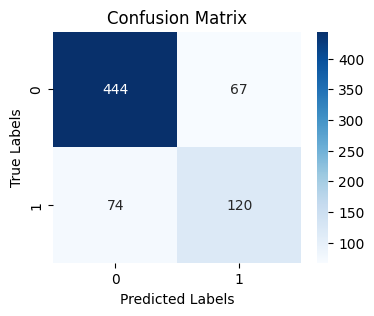

In [102]:
# Calculate the Confusion Matrix
lgbm_conf_matrix = confusion_matrix(y_test, lgbm_y_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(4, 3))
sns.heatmap(lgbm_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### [5.4.2] Classification Report

In [103]:
print(classification_report(y_test, lgbm_y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       511
           1       0.64      0.62      0.63       194

    accuracy                           0.80       705
   macro avg       0.75      0.74      0.75       705
weighted avg       0.80      0.80      0.80       705



### [5.4.3] Metrics

In [104]:
lgbm_accuracy = accuracy_score(y_test, lgbm_y_pred)
lgbm_precision = precision_score(y_test, lgbm_y_pred)
lgbm_recall = recall_score(y_test, lgbm_y_pred)
lgbm_f1 = f1_score(y_test, lgbm_y_pred)
lgbm_roc_auc = roc_auc_score(y_test, lgbm_y_pred)

print("Accuracy:", lgbm_accuracy)
print("Precision:", lgbm_precision)
print("Recall:", lgbm_recall)
print("F1:", lgbm_f1)
print("ROC-AUC:", lgbm_roc_auc)

Accuracy: 0.8
Precision: 0.6417112299465241
Recall: 0.6185567010309279
F1: 0.6299212598425197
ROC-AUC: 0.7437206205741723


## [5.5] MLFlow

In [105]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# Set Tracking
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Set Experiment Name
mlflow.set_experiment("lgbm_churn-classification")

# Infer model signature (schema)
lgbm_signature = infer_signature(x_train_over, lgbm_y_pred)

# Use a sample of your input as input_example
lgbm_input_example = x_train_over.sample(5)

# Start MLflow run
with mlflow.start_run():
    # Log parameters
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_estimators", lgbm_n_estimators_optimal)
    mlflow.log_param("learning_rate", lgbm_learning_rate_optimal)
    mlflow.log_param("max_depth", lgbm_max_depth_optimal)
    mlflow.log_param("num_leaves", lgbm_num_leaves_optimal)
    mlflow.log_param("min_child_samples", lgbm_min_child_samples_optimal)
    mlflow.log_param("colsample_bytree", lgbm_colsample_bytree_optimal)
    mlflow.log_param("reg_alpha", lgbm_reg_alpha_optimal)
    mlflow.log_param("reg_lambda", lgbm_reg_lambda_optimal)
    
    # Log metrics
    mlflow.log_metric("accuracy", lgbm_accuracy)
    mlflow.log_metric("precision", lgbm_precision)
    mlflow.log_metric("recall", lgbm_recall)
    mlflow.log_metric("f1", lgbm_f1)
    mlflow.log_metric("roc_auc", lgbm_roc_auc)

    # Log model
    mlflow.sklearn.log_model(lgbm_model_final, "lgbm_model", signature=lgbm_signature, input_example=lgbm_input_example)

2025/04/23 16:07:12 INFO mlflow.tracking.fluent: Experiment with name 'lgbm_churn-classification' does not exist. Creating a new experiment.


🏃 View run melodic-deer-304 at: http://127.0.0.1:5000/#/experiments/469565351085525225/runs/8842c09f740c4bc5bca766f1c25e4249
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/469565351085525225


# [6] XGBoost

## [6.1] Initialize the Model

In [20]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os
os.environ["PYTHONWARNINGS"] = "ignore::FutureWarning"

from xgboost import XGBClassifier

# Initialize the Model
xgb_model = XGBClassifier(verbosity=0, random_state=42)


## [6.2] Optimize the Model

In [21]:
# Define Parameter Space
xgb_param_space = {
                    'n_estimators': [],
                    'learning_rate': [],

                    'max_depth': [],
                    'min_child_weight': [],

                    'colsample_bytree': [],
                    'gamma': [],

                    'reg_alpha': [],
                    'reg_lambda': [],
                }

# Initialize the optimizer
xgb_optimizer = HyperparameterOptimizer(
                                            obj_func=xgb_model,
                                            params=xgb_param_space,
                                            scoring='accuracy',
                                            opt_type='max',
                                            cv=5,
                                            verbose=1
                                    )
                                    
# Run optimization
res_xgb = xgb_optimizer.optimizePS(
                                        features=x_train_over,
                                        target=y_train_over,
                                        nParticles=5,
                                        bounds=[
                                                    (100, 1000), (0.01, 0.20),
                                                    (3, 10), (1, 10),
                                                    (0.5, 1.0), (0, 5),
                                                    (0.0, 1.0), (0.0, 1.0)
                                                ],
                                        w=0.5,
                                        c1=1.3,
                                        c2=1.3,
                                        maxIter=20,
                                        mutation_prob=0.7
                            )

PS hyperparameter optimization has started . . .
Initializing Global Best Position and Score . . .
Initializing Swarm Particles . . .
Starting Optimization Main Loop . . .
Iteration #1
Corresponding Optimal Solution: [100 0.2 3 1 0.5 0 0.0 1.0]
Corresponding Optimum: 0.849452686568451
------
Iteration #2
Corresponding Optimal Solution: [100 0.2 3 1 0.5 0 0.0 1.0]
Corresponding Optimum: 0.849452686568451
------
Iteration #3
Corresponding Optimal Solution: [100 0.2 3 1 0.5 0 0.0 1.0]
Corresponding Optimum: 0.849452686568451
------
Iteration #4
Corresponding Optimal Solution: [100 0.2 10 1 0.5 0 0.0 1.0]
Corresponding Optimum: 0.8548139846957981
------
Iteration #5
Corresponding Optimal Solution: [100 0.2 10 1 0.5 0 0.0 1.0]
Corresponding Optimum: 0.8548139846957981
------
Iteration #6
Corresponding Optimal Solution: [100 0.2 10 1 0.5 0 0.0 1.0]
Corresponding Optimum: 0.8548139846957981
------
Iteration #7
Corresponding Optimal Solution: [100 0.2 10 1 0.5 0 0.0 1.0]
Corresponding Optimum:

In [22]:
# Get the Optimal Hyperparameter Values
xgb_n_estimators_optimal = xgb_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][0]
print(f"Optimal n_estimators: {xgb_n_estimators_optimal}")

xgb_learning_rate_optimal = xgb_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][1]
print(f"Optimal learning_rate: {xgb_learning_rate_optimal}")

xgb_max_depth_optimal = xgb_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][2]
print(f"Optimal max_depth: {xgb_max_depth_optimal}")

xgb_min_child_weight_optimal = xgb_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][3]
print(f"Optimal min_child_weight: {xgb_min_child_weight_optimal}")

xgb_colsample_bytree_optimal = xgb_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][4]
print(f"Optimal min_child_samples: {xgb_colsample_bytree_optimal}")

xgb_gamma_optimal = xgb_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][5]
print(f"Optimal colsample_bytree: {xgb_gamma_optimal}")

xgb_reg_alpha_optimal = xgb_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][6]
print(f"Optimal reg_alpha: {xgb_reg_alpha_optimal}")

xgb_reg_lambda_optimal = xgb_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][7]
print(f"Optimal reg_lambda: {xgb_reg_lambda_optimal}")

Optimal n_estimators: 1000
Optimal learning_rate: 0.01
Optimal max_depth: 10
Optimal min_child_weight: 1
Optimal min_child_samples: 0.5
Optimal colsample_bytree: 0
Optimal reg_alpha: 1.0
Optimal reg_lambda: 1.0


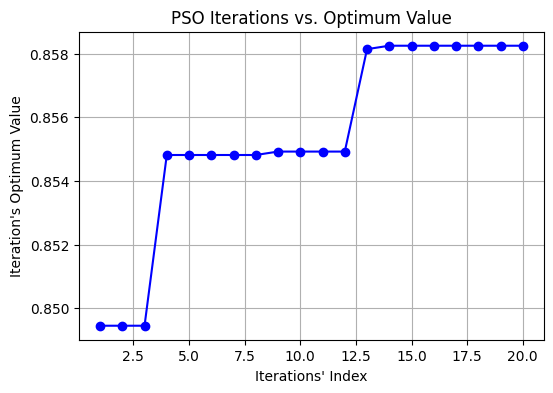

In [23]:
# Plot the Results
plot_ps_iter_opt_sols(xgb_optimizer.PS_iterOptSols)

## [6.3] Train the Model

In [24]:
# Build the Final Model
xgb_model_final = XGBClassifier(
                                        n_estimators=xgb_n_estimators_optimal,
                                        learning_rate=xgb_learning_rate_optimal,

                                        max_depth=xgb_max_depth_optimal,
                                        min_child_weight=xgb_min_child_weight_optimal,

                                        colsample_bytree=xgb_colsample_bytree_optimal,
                                        gamma=xgb_gamma_optimal,

                                        reg_alpha=xgb_reg_alpha_optimal,
                                        reg_lambda=xgb_reg_lambda_optimal,

                                        random_state=42,
                                        verbosity=0
                                )

# Fit the Final Model
xgb_model_final.fit(x_train_over, y_train_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

## [6.4] Test the Results

In [25]:
# Import the required libraries
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predict the target values
xgb_y_pred = xgb_model_final.predict(x_test)

### [6.4.1] Confusion Matrix

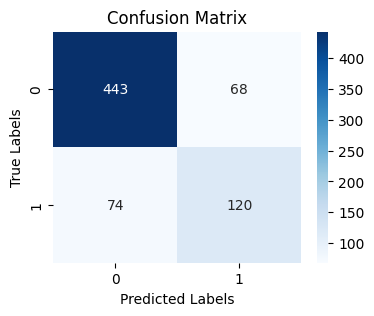

In [26]:
# Calculate the Confusion Matrix
xgb_conf_matrix = confusion_matrix(y_test, xgb_y_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(4, 3))
sns.heatmap(xgb_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### [6.4.2] Classification Report

In [27]:
print(classification_report(y_test, xgb_y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       511
           1       0.64      0.62      0.63       194

    accuracy                           0.80       705
   macro avg       0.75      0.74      0.75       705
weighted avg       0.80      0.80      0.80       705



### [6.4.3] Metrics

In [28]:
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_f1 = f1_score(y_test, xgb_y_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_y_pred)

print("Accuracy:", xgb_accuracy)
print("Precision:", xgb_precision)
print("Recall:", xgb_recall)
print("F1:", xgb_f1)
print("ROC-AUC:", xgb_roc_auc)

Accuracy: 0.798581560283688
Precision: 0.6382978723404256
Recall: 0.6185567010309279
F1: 0.6282722513089005
ROC-AUC: 0.742742146992959


## [6.5] MLFlow

In [29]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# Set Tracking
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Set Experiment Name
mlflow.set_experiment("xgb_churn-classification")

# Infer model signature (schema)
xgb_signature = infer_signature(x_train_over, xgb_y_pred)

# Use a sample of your input as input_example
xgb_input_example = x_train_over.sample(5)

# Start MLflow run
with mlflow.start_run():
    # Log parameters
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_estimators", xgb_n_estimators_optimal)
    mlflow.log_param("learning_rate", xgb_learning_rate_optimal)
    mlflow.log_param("max_depth", xgb_max_depth_optimal)
    mlflow.log_param("min_child_weight", xgb_min_child_weight_optimal)
    mlflow.log_param("colsample_bytree", xgb_colsample_bytree_optimal)
    mlflow.log_param("gamma", xgb_gamma_optimal)
    mlflow.log_param("reg_alpha", xgb_reg_alpha_optimal)
    mlflow.log_param("reg_lambda", xgb_reg_lambda_optimal)
    
    # Log metrics
    mlflow.log_metric("accuracy", xgb_accuracy)
    mlflow.log_metric("precision", xgb_precision)
    mlflow.log_metric("recall", xgb_recall)
    mlflow.log_metric("f1", xgb_f1)
    mlflow.log_metric("roc_auc", xgb_roc_auc)

    # Log model
    mlflow.sklearn.log_model(xgb_model_final, "xgb_model", signature=xgb_signature, input_example=xgb_input_example)

2025/04/24 20:35:32 INFO mlflow.tracking.fluent: Experiment with name 'xgb_churn-classification' does not exist. Creating a new experiment.


🏃 View run nebulous-swan-250 at: http://127.0.0.1:5000/#/experiments/618106129079529140/runs/cbd4428d51be473ba3232eedaeb09019
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/618106129079529140


# [7] CatBoost

## [7.1] Initialize the Model

In [34]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os
os.environ["PYTHONWARNINGS"] = "ignore::FutureWarning"

from catboost import CatBoostClassifier

# Initialize the Model
cb_model = CatBoostClassifier(verbose=0, random_state=42)

## [7.2] Optimize the Model

In [35]:
# Define Parameter Space
cb_param_space = {
                    'iterations': [],
                    'learning_rate': [],

                    'depth': [],
                    'l2_leaf_reg': [],

                    'bagging_temperature': [],
                    'border_count': []
                }

# Initialize the optimizer
cb_optimizer = HyperparameterOptimizer(
                                            obj_func=cb_model,
                                            params=cb_param_space,
                                            scoring='accuracy',
                                            opt_type='max',
                                            cv=5,
                                            verbose=1
                                    )
                                    
# Run optimization
res_cb = cb_optimizer.optimizePS(
                                        features=x_train_over,
                                        target=y_train_over,
                                        nParticles=5,
                                        bounds=[
                                                    (100, 1000), (0.01, 0.20),
                                                    (4, 10), (1, 10),
                                                    (0.0, 1.0), (32, 255)
                                                ],
                                        w=0.5,
                                        c1=1.3,
                                        c2=1.3,
                                        maxIter=20,
                                        mutation_prob=0.7
                            )

PS hyperparameter optimization has started . . .
Initializing Global Best Position and Score . . .
Initializing Swarm Particles . . .
Starting Optimization Main Loop . . .
Iteration #1
Corresponding Optimal Solution: [100 0.01 4 1 0.0 255]
Corresponding Optimum: 0.8532057504259946
------
Iteration #2
Corresponding Optimal Solution: [100 0.01 4 1 0.0 255]
Corresponding Optimum: 0.8532057504259946
------
Iteration #3
Corresponding Optimal Solution: [100 0.01 4 1 0.0 255]
Corresponding Optimum: 0.8532057504259946
------
Iteration #4
Corresponding Optimal Solution: [100 0.01 4 1 0.0 255]
Corresponding Optimum: 0.8532057504259946
------
Iteration #5
Corresponding Optimal Solution: [100 0.01 4 1 0.0 255]
Corresponding Optimum: 0.8532057504259946
------
Iteration #6
Corresponding Optimal Solution: [100 0.01 4 1 0.0 255]
Corresponding Optimum: 0.8532057504259946
------
Iteration #7
Corresponding Optimal Solution: [100 0.01 4 1 0.0 255]
Corresponding Optimum: 0.8532057504259946
------
Iteration

In [36]:
# Get the Optimal Hyperparameter Values
cb_iterations_optimal = cb_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][0]
print(f"Optimal iterations: {cb_iterations_optimal}")

cb_learning_rate_optimal = cb_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][1]
print(f"Optimal learning_rate: {cb_learning_rate_optimal}")

cb_depth_optimal = cb_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][2]
print(f"Optimal depth: {cb_depth_optimal}")

cb_l2_leaf_reg_optimal = cb_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][3]
print(f"Optimal l2_leaf_reg: {cb_l2_leaf_reg_optimal}")

cb_bagging_temperature_optimal = cb_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][4]
print(f"Optimal bagging_temperature: {cb_bagging_temperature_optimal}")

cb_border_count_optimal = cb_optimizer.PS_finalOptimalSol["Optimal Solution Variables' Values"][5]
print(f"Optimal border_count: {cb_border_count_optimal}")

Optimal iterations: 100
Optimal learning_rate: 0.01
Optimal depth: 4
Optimal l2_leaf_reg: 1
Optimal bagging_temperature: 0.0
Optimal border_count: 255


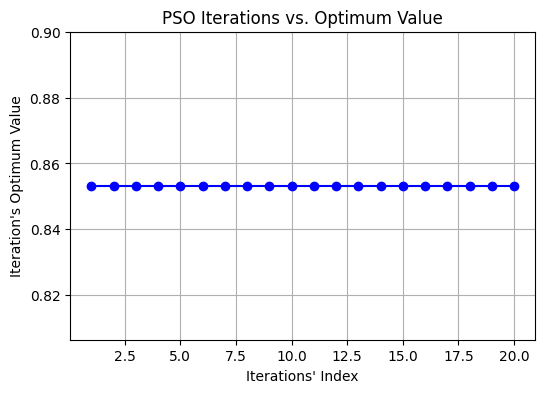

In [37]:
# Plot the Results
plot_ps_iter_opt_sols(cb_optimizer.PS_iterOptSols)

## [7.3] Train the Model

In [38]:
# Build the Final Model
cb_model_final = CatBoostClassifier(
                                        iterations=cb_iterations_optimal,
                                        learning_rate=cb_learning_rate_optimal,

                                        depth=cb_depth_optimal,
                                        l2_leaf_reg=cb_l2_leaf_reg_optimal,

                                        bagging_temperature=cb_bagging_temperature_optimal,
                                        border_count=cb_border_count_optimal,

                                        random_state=42,
                                        verbose=0
                                )

# Fit the Final Model
cb_model_final.fit(x_train_over, y_train_over)

## [7.4] Test the Results

In [39]:
# Import the required libraries
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predict the target values
cb_y_pred = cb_model_final.predict(x_test)

### [7.4.1] Confusion Matrix

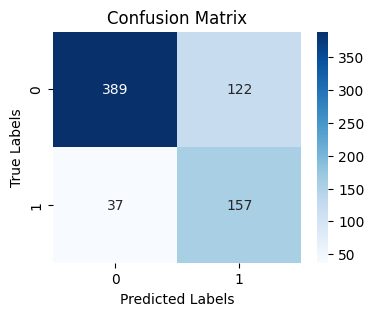

In [40]:
# Calculate the Confusion Matrix
cb_conf_matrix = confusion_matrix(y_test, cb_y_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cb_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### [7.4.2] Classification Report

In [41]:
print(classification_report(y_test, cb_y_pred))

              precision    recall  f1-score   support

           0       0.91      0.76      0.83       511
           1       0.56      0.81      0.66       194

    accuracy                           0.77       705
   macro avg       0.74      0.79      0.75       705
weighted avg       0.82      0.77      0.78       705



### [7.4.3] Metrics

In [42]:
cb_accuracy = accuracy_score(y_test, cb_y_pred)
cb_precision = precision_score(y_test, cb_y_pred)
cb_recall = recall_score(y_test, cb_y_pred)
cb_f1 = f1_score(y_test, cb_y_pred)
cb_roc_auc = roc_auc_score(y_test, cb_y_pred)

print("Accuracy:", cb_accuracy)
print("Precision:", cb_precision)
print("Recall:", cb_recall)
print("F1:", cb_f1)
print("ROC-AUC:", cb_roc_auc)

Accuracy: 0.774468085106383
Precision: 0.5627240143369175
Recall: 0.8092783505154639
F1: 0.6638477801268499
ROC-AUC: 0.7852653983497085


## [7.5] MLFlow

In [43]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# Set Tracking
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Set Experiment Name
mlflow.set_experiment("cb_churn-classification")

# Infer model signature (schema)
cb_signature = infer_signature(x_train_over, cb_y_pred)

# Use a sample of your input as input_example
cb_input_example = x_train_over.sample(5)

# Start MLflow run
with mlflow.start_run():
    # Log parameters
    mlflow.log_param("random_state", 42)
    mlflow.log_param("iterations", cb_iterations_optimal)
    mlflow.log_param("learning_rate", cb_learning_rate_optimal)
    mlflow.log_param("depth", cb_depth_optimal)
    mlflow.log_param("l2_leaf_reg", cb_l2_leaf_reg_optimal)
    mlflow.log_param("bagging_temperature", cb_bagging_temperature_optimal)
    mlflow.log_param("border_count", cb_border_count_optimal)
    
    # Log metrics
    mlflow.log_metric("accuracy", cb_accuracy)
    mlflow.log_metric("precision", cb_precision)
    mlflow.log_metric("recall", cb_recall)
    mlflow.log_metric("f1", cb_f1)
    mlflow.log_metric("roc_auc", cb_roc_auc)

    # Log model
    mlflow.sklearn.log_model(cb_model_final, "cb_model", signature=cb_signature, input_example=cb_input_example)

2025/04/24 21:39:49 INFO mlflow.tracking.fluent: Experiment with name 'cb_churn-classification' does not exist. Creating a new experiment.


🏃 View run selective-skink-515 at: http://127.0.0.1:5000/#/experiments/308430599642473417/runs/456aaf6458594e3496b15616901951e4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/308430599642473417


# [8] Plotting

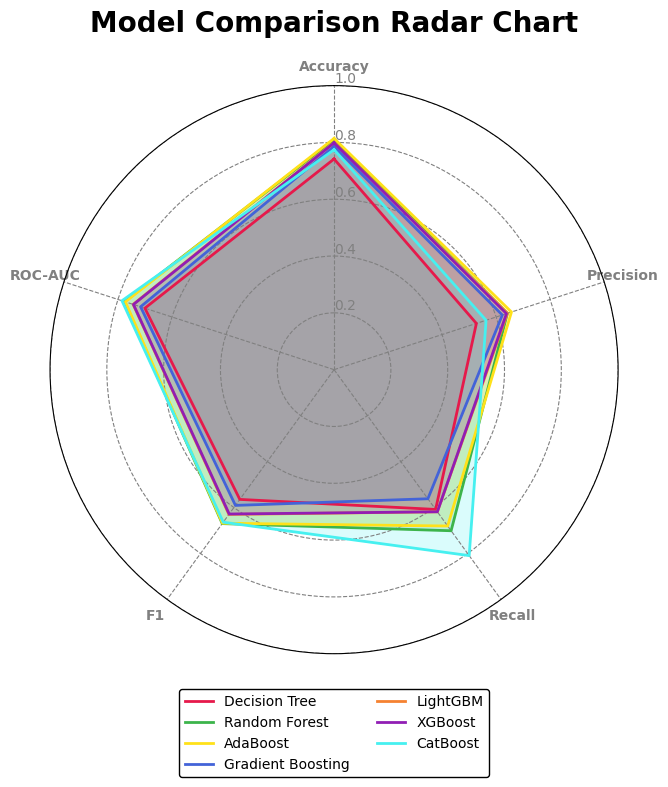

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
models = ['Decision Tree', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'LightGBM', 'XGBoost', 'CatBoost']
data = [
    [0.7418, 0.5268, 0.6082, 0.5646, 0.7004],  # dt
    [0.8099, 0.6415, 0.7010, 0.6699, 0.7761],  # RF
    [0.8141, 0.6567, 0.6804, 0.6683, 0.7726],  # AdaBoost
    [0.7858, 0.6228, 0.5618, 0.5907, 0.7163],  # GB
    [0.8,    0.6417, 0.6185, 0.6299, 0.7437],  # LightGBM
    [0.7985, 0.6382, 0.6185, 0.6282, 0.7427],  # XGBoost
    [0.7744, 0.5627, 0.8092, 0.6638, 0.7852],  # CatBoost
]

# Setup for the radar chart
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# **Define custom high-contrast colors**
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0']

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
fig.patch.set_facecolor('white')

# Plot each model
for idx, model_data in enumerate(data):
    values = model_data + model_data[:1]
    ax.plot(angles, values, label=models[idx], color=colors[idx], linewidth=2)
    ax.fill(angles, values, color=colors[idx], alpha=0.2)

# Add labels
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=12, fontweight='bold')

# Style radial axis
ax.set_rlabel_position(0)
ax.tick_params(colors='grey', labelsize=10)
ax.grid(color='grey', linestyle='dashed')
ax.spines['polar'].set_color('black')

# Set 0-1 range
ax.set_ylim(0, 1)

# Add legend outside the plot
legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
                    ncol=2, fontsize=10, frameon=True, framealpha=1, facecolor='white', edgecolor='black')

# Title
plt.title('Model Comparison Radar Chart', size=20, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()


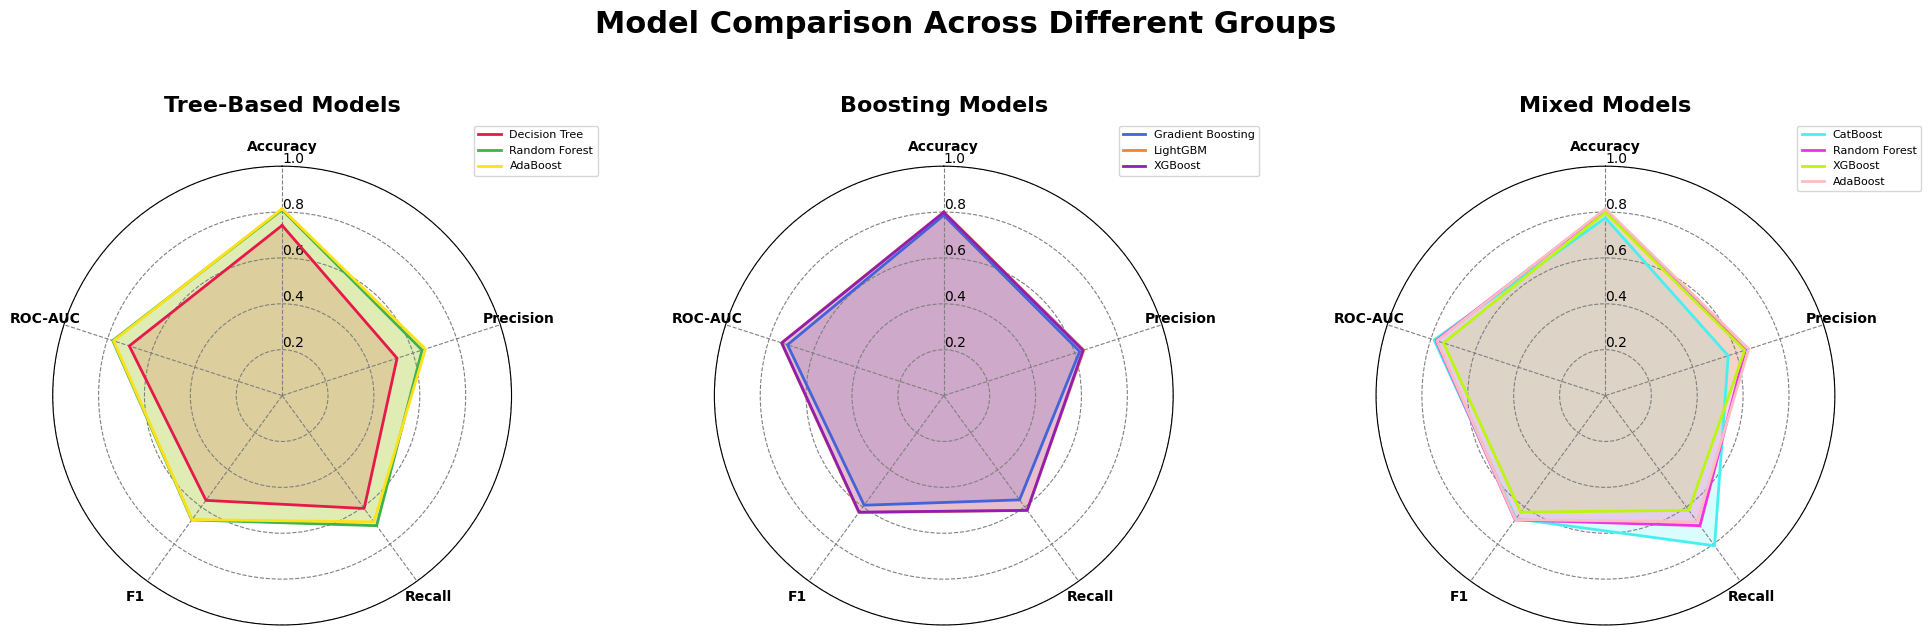

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
models = ['Decision Tree', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'LightGBM', 'XGBoost', 'CatBoost']
data = [
    [0.7418, 0.5268, 0.6082, 0.5646, 0.7004],  # dt
    [0.8099, 0.6415, 0.7010, 0.6699, 0.7761],  # RF
    [0.8141, 0.6567, 0.6804, 0.6683, 0.7726],  # AdaBoost
    [0.7858, 0.6228, 0.5618, 0.5907, 0.7163],  # GB
    [0.8,    0.6417, 0.6185, 0.6299, 0.7437],  # LightGBM
    [0.7985, 0.6382, 0.6185, 0.6282, 0.7427],  # XGBoost
    [0.7744, 0.5627, 0.8092, 0.6638, 0.7852],  # CatBoost
]

# Setup for the radar chart
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Define 3 sets of distinct colors
colors1 = ['#e6194b', '#3cb44b', '#ffe119']   # vivid red, green, yellow
colors2 = ['#4363d8', '#f58231', '#911eb4']   # vivid blue, orange, purple
colors3 = ['#46f0f0', '#f032e6', '#bcf60c', '#fabebe']  # cyan, pink, lime, light pink

# Group the models differently in each subplot
groups = [
    [0, 1, 2],  # Decision Tree, Random Forest, AdaBoost
    [3, 4, 5],  # Gradient Boosting, LightGBM, XGBoost
    [6, 1, 5, 2],  # CatBoost, Random Forest, XGBoost, AdaBoost (mix and match!)
]

# Create 1 figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 6), subplot_kw=dict(polar=True))
fig.patch.set_facecolor('white')

# Titles for each plot
titles = ['Tree-Based Models', 'Boosting Models', 'Mixed Models']

# Colors for each plot
color_sets = [colors1, colors2, colors3]

# Create each radar chart
for i, ax in enumerate(axs):
    group = groups[i]
    colors = color_sets[i]
    for idx, model_idx in enumerate(group):
        values = data[model_idx] + data[model_idx][:1]
        ax.plot(angles, values, label=models[model_idx], color=colors[idx % len(colors)], linewidth=2)
        ax.fill(angles, values, color=colors[idx % len(colors)], alpha=0.2)
    
    # Radar settings
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=10, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.set_rlabel_position(0)
    ax.grid(color='grey', linestyle='dashed')
    ax.spines['polar'].set_color('black')
    ax.set_title(titles[i], size=16, fontweight='bold', pad=20)

    # Add legend inside each radar
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=8, frameon=True, facecolor='white')

# Adjust layout
plt.suptitle('Model Comparison Across Different Groups', size=22, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()
